In [2]:
import numpy as np
from sklearn.preprocessing import label_binarize

# Definisci l'ordine target delle classi (stringhe)
target_classes = ['movie', 'short', 'tvEpisode', 'tvMiniSeries', 'tvMovie', 'tvSeries', 'tvSpecial', 'video']
label_map = {str(i): label for i, label in enumerate(target_classes)}


def load_and_prepare_model_data(model_name, use_label_map=False):
    target_classes = ['movie', 'short', 'tvEpisode', 'tvMiniSeries', 'tvMovie', 'tvSeries', 'tvSpecial', 'video']

    y_true = np.load(f'y_true_{model_name}_multiclass.npy', allow_pickle=True)
    y_score = np.load(f'y_scores_{model_name}_multiclass.npy', allow_pickle=True)

    # Auto-detect se serve mapping
    if use_label_map:
        if np.issubdtype(y_true.dtype, np.integer):
            label_map = {i: label for i, label in enumerate(target_classes)}
            y_true = np.array([label_map[label] for label in y_true])
        elif np.issubdtype(y_true.dtype, np.str_):
            pass  # Già stringhe
        else:
            raise ValueError("Tipo y_true non riconosciuto")

    # Ordina colonne y_score secondo target_classes
    if y_score.shape[1] == len(target_classes):
        # Prendi l'ordine delle classi nel modello dal nome dei file o definizione
        classes = target_classes if model_name == "dt" else [str(i) for i in range(len(target_classes))]
        index_map = [classes.index(str(i)) if str(i) in classes else i for i in range(len(classes))]
        y_score = y_score[:, index_map]

    return y_true, y_score



#### con errore
# def load_and_prepare_model_data(prefix, use_label_map=False):
#     """
#     prefix: es. 'dt', 'nb', 'knn'
#     use_label_map: True se le classi del modello sono numeriche (come NB e KNN)
#     """
#     y_true = np.load(f'y_true_{prefix}_multiclass.npy', allow_pickle=True)
#     y_score = np.load(f'y_scores_{prefix}_multiclass.npy', allow_pickle=True)
#     classes = np.load(f'classes_{prefix}.npy', allow_pickle=True)

#     # Assicura classi come stringhe
#     classes = list(map(str, classes))

#     if use_label_map:
#         # Mappa classi numeriche a nomi
#         classes = [label_map[c] for c in classes]

#     # Controlla e allinea gli score secondo target_classes
#     # index_map = [classes.index(c) for c in target_classes]
#     # y_score_aligned = y_score[:, index_map]
#     index_map = [classes.index(c) for c in target_classes]
#     y_score_aligned = y_score[:, index_map]

############ errore
#     # Se y_true contiene numeri da 0 a 7
#     label_map = {str(i): label for i, label in enumerate(target_classes)}
#     y_true = np.array([label_map[str(label)] for label in y_true])
#####################à
#     # Binarizza y_true
#     y_true_bin = label_binarize(y_true, classes=target_classes)

#     return y_true_bin, y_score_aligned


In [3]:
# Decision Tree → usa stringhe già giuste
y_true_dt, y_score_dt = load_and_prepare_model_data("dt")

# NB e KNN → usano numeri, attiva il mapping
y_true_nb, y_score_nb = load_and_prepare_model_data("nb", use_label_map=True)
y_true_knn, y_score_knn = load_and_prepare_model_data("knn", use_label_map=True)


In [4]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def compute_macro_roc(y_true, y_score, classes):
    # Binarizza y_true (necessario per multiclass ROC)
    y_true_bin = label_binarize(y_true, classes=classes)
    
    fpr = dict()
    tpr = dict()

    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
    mean_tpr = np.zeros_like(all_fpr)
    
    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    
    mean_tpr /= len(classes)
    return all_fpr, mean_tpr, auc(all_fpr, mean_tpr)



In [5]:
fpr_dt, tpr_dt, auc_dt = compute_macro_roc(y_true_dt, y_score_dt, target_classes)
fpr_nb, tpr_nb, auc_nb = compute_macro_roc(y_true_nb, y_score_nb, target_classes)
fpr_knn, tpr_knn, auc_knn = compute_macro_roc(y_true_knn, y_score_knn, target_classes)


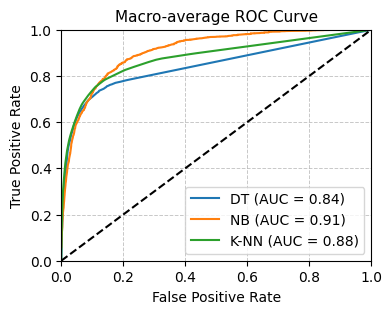

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,3))
plt.plot(fpr_dt, tpr_dt, label=f'DT (AUC = {auc_dt:.2f})')
plt.plot(fpr_nb, tpr_nb, label=f'NB (AUC = {auc_nb:.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'K-NN (AUC = {auc_knn:.2f})')
plt.plot([0, 1], [0, 1], 'k--')

plt.title('Macro-average ROC Curve', fontsize=11)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.7, linestyle='--', linewidth=0.7)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.show()
